In [1]:
 import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learning import ReachingTask
import pandas as pd
from tqdm import tqdm, trange
import matplotlib
import matplotlib as mpl
from scipy import stats

In [8]:
# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
font = {'family' : 'arial',
        'weight' : 'light',
        'size'   : 18}

matplotlib.rc('font', **font)

mpl.rcParams['axes.linewidth'] = 2

# Filename and Directory

In [25]:
filename = 'learning-env-40-0.03-1100-0.6-01'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# values = data['values']
# rpes = data['rpes']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
# state_ctx = data['state_ctx']
# state_d1 = data['state_d1']

### Overlap vs Time

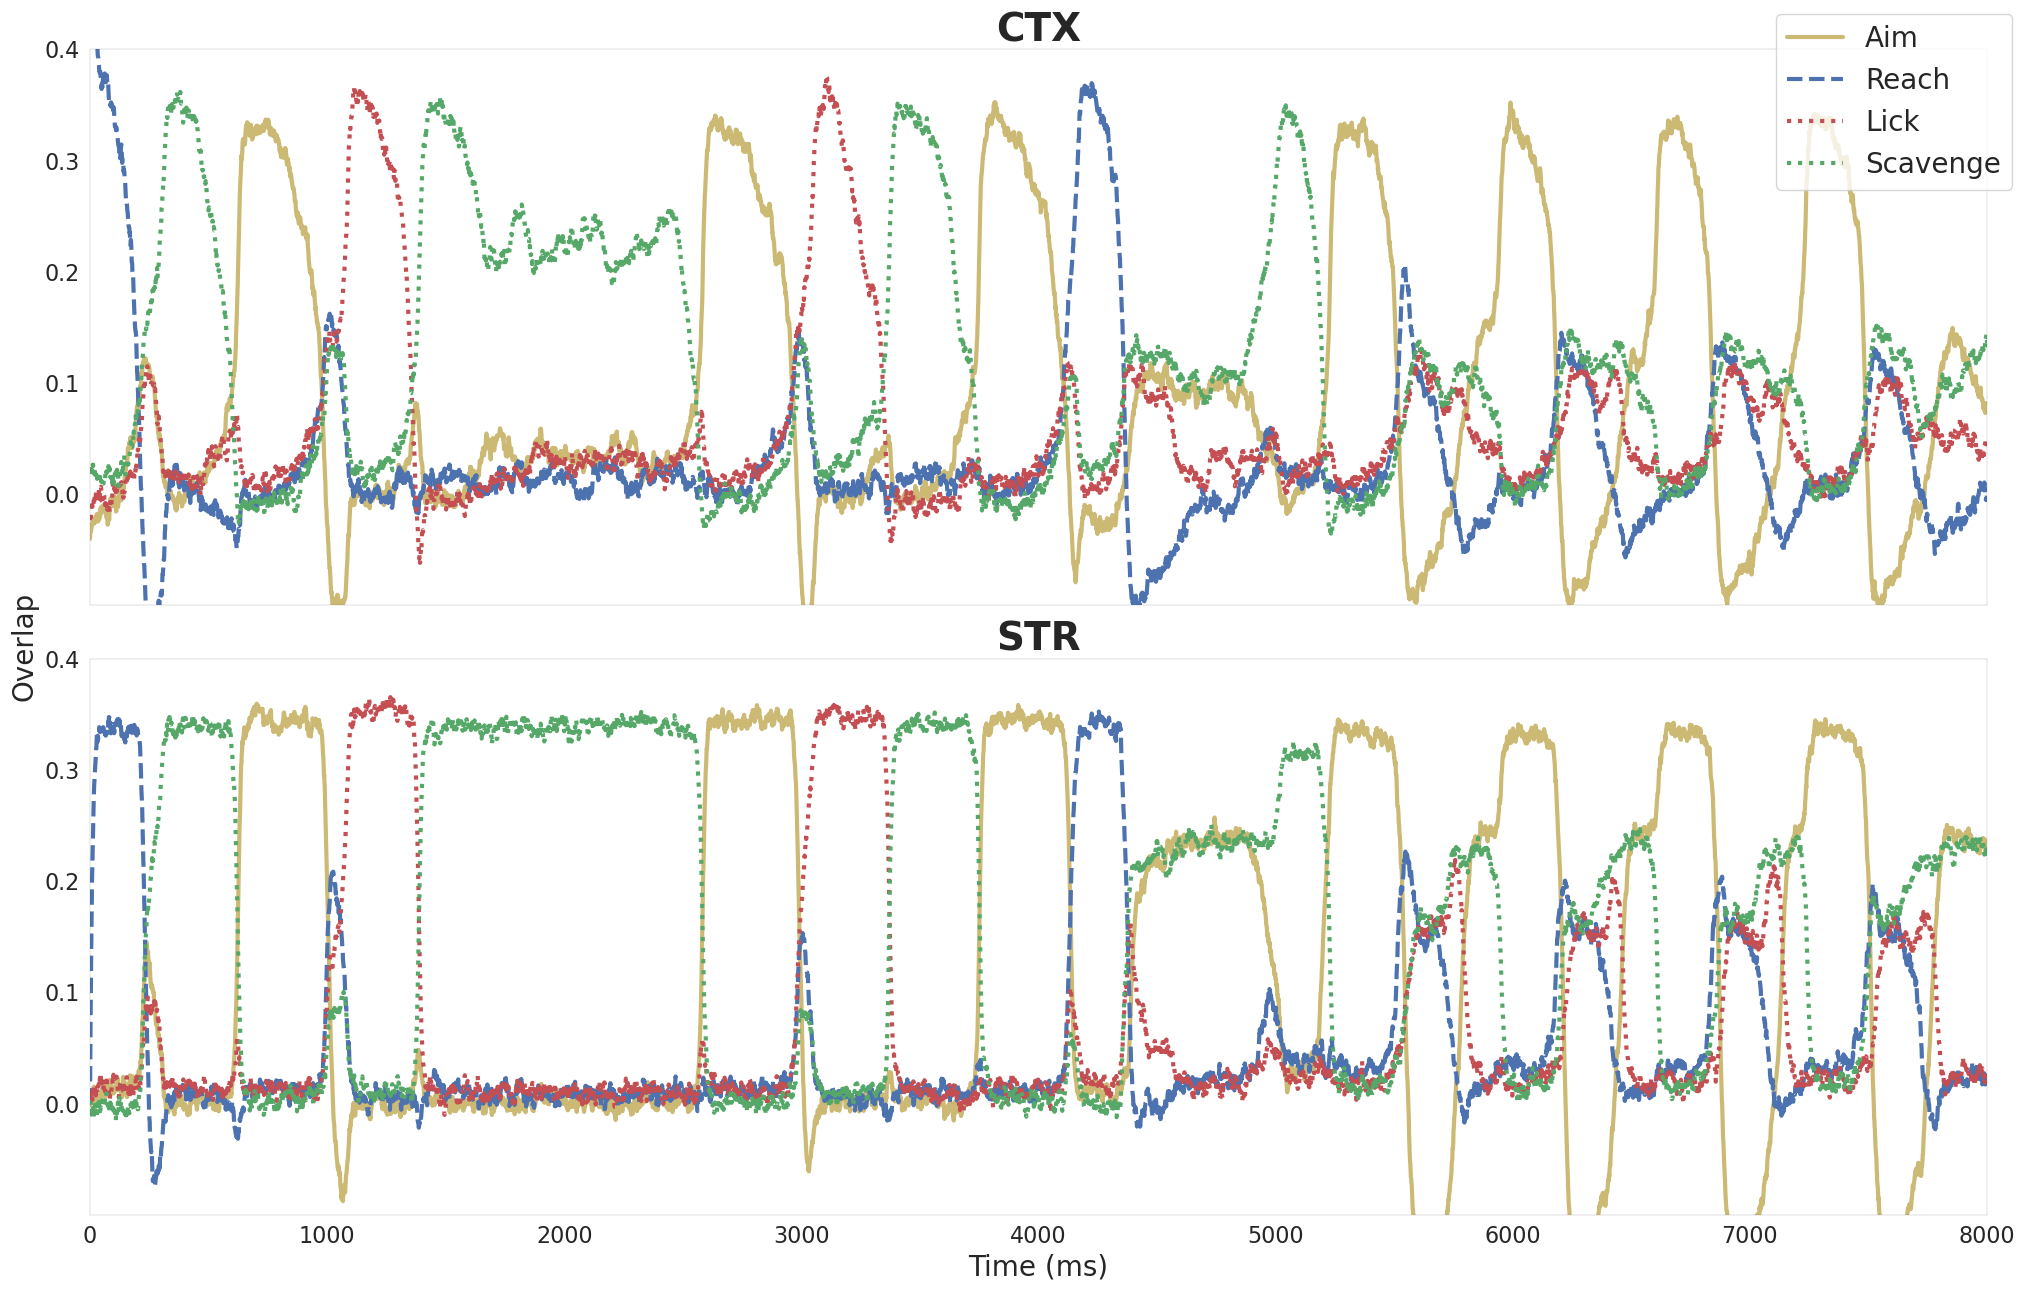

In [26]:
### Overlap 
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=28, weight='bold')
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=28, weight='bold')
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 8000))
plt.setp(axes, ylim=(-0.1, 0.4))
plt.figlegend(labels=['Aim', 'Reach', 'Lick', 'Scavenge'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/online-learning4.jpg', bbox_inches = "tight", format='jpg')
# plt.show()



### Raster Plot

NameError: name 'state_d1' is not defined

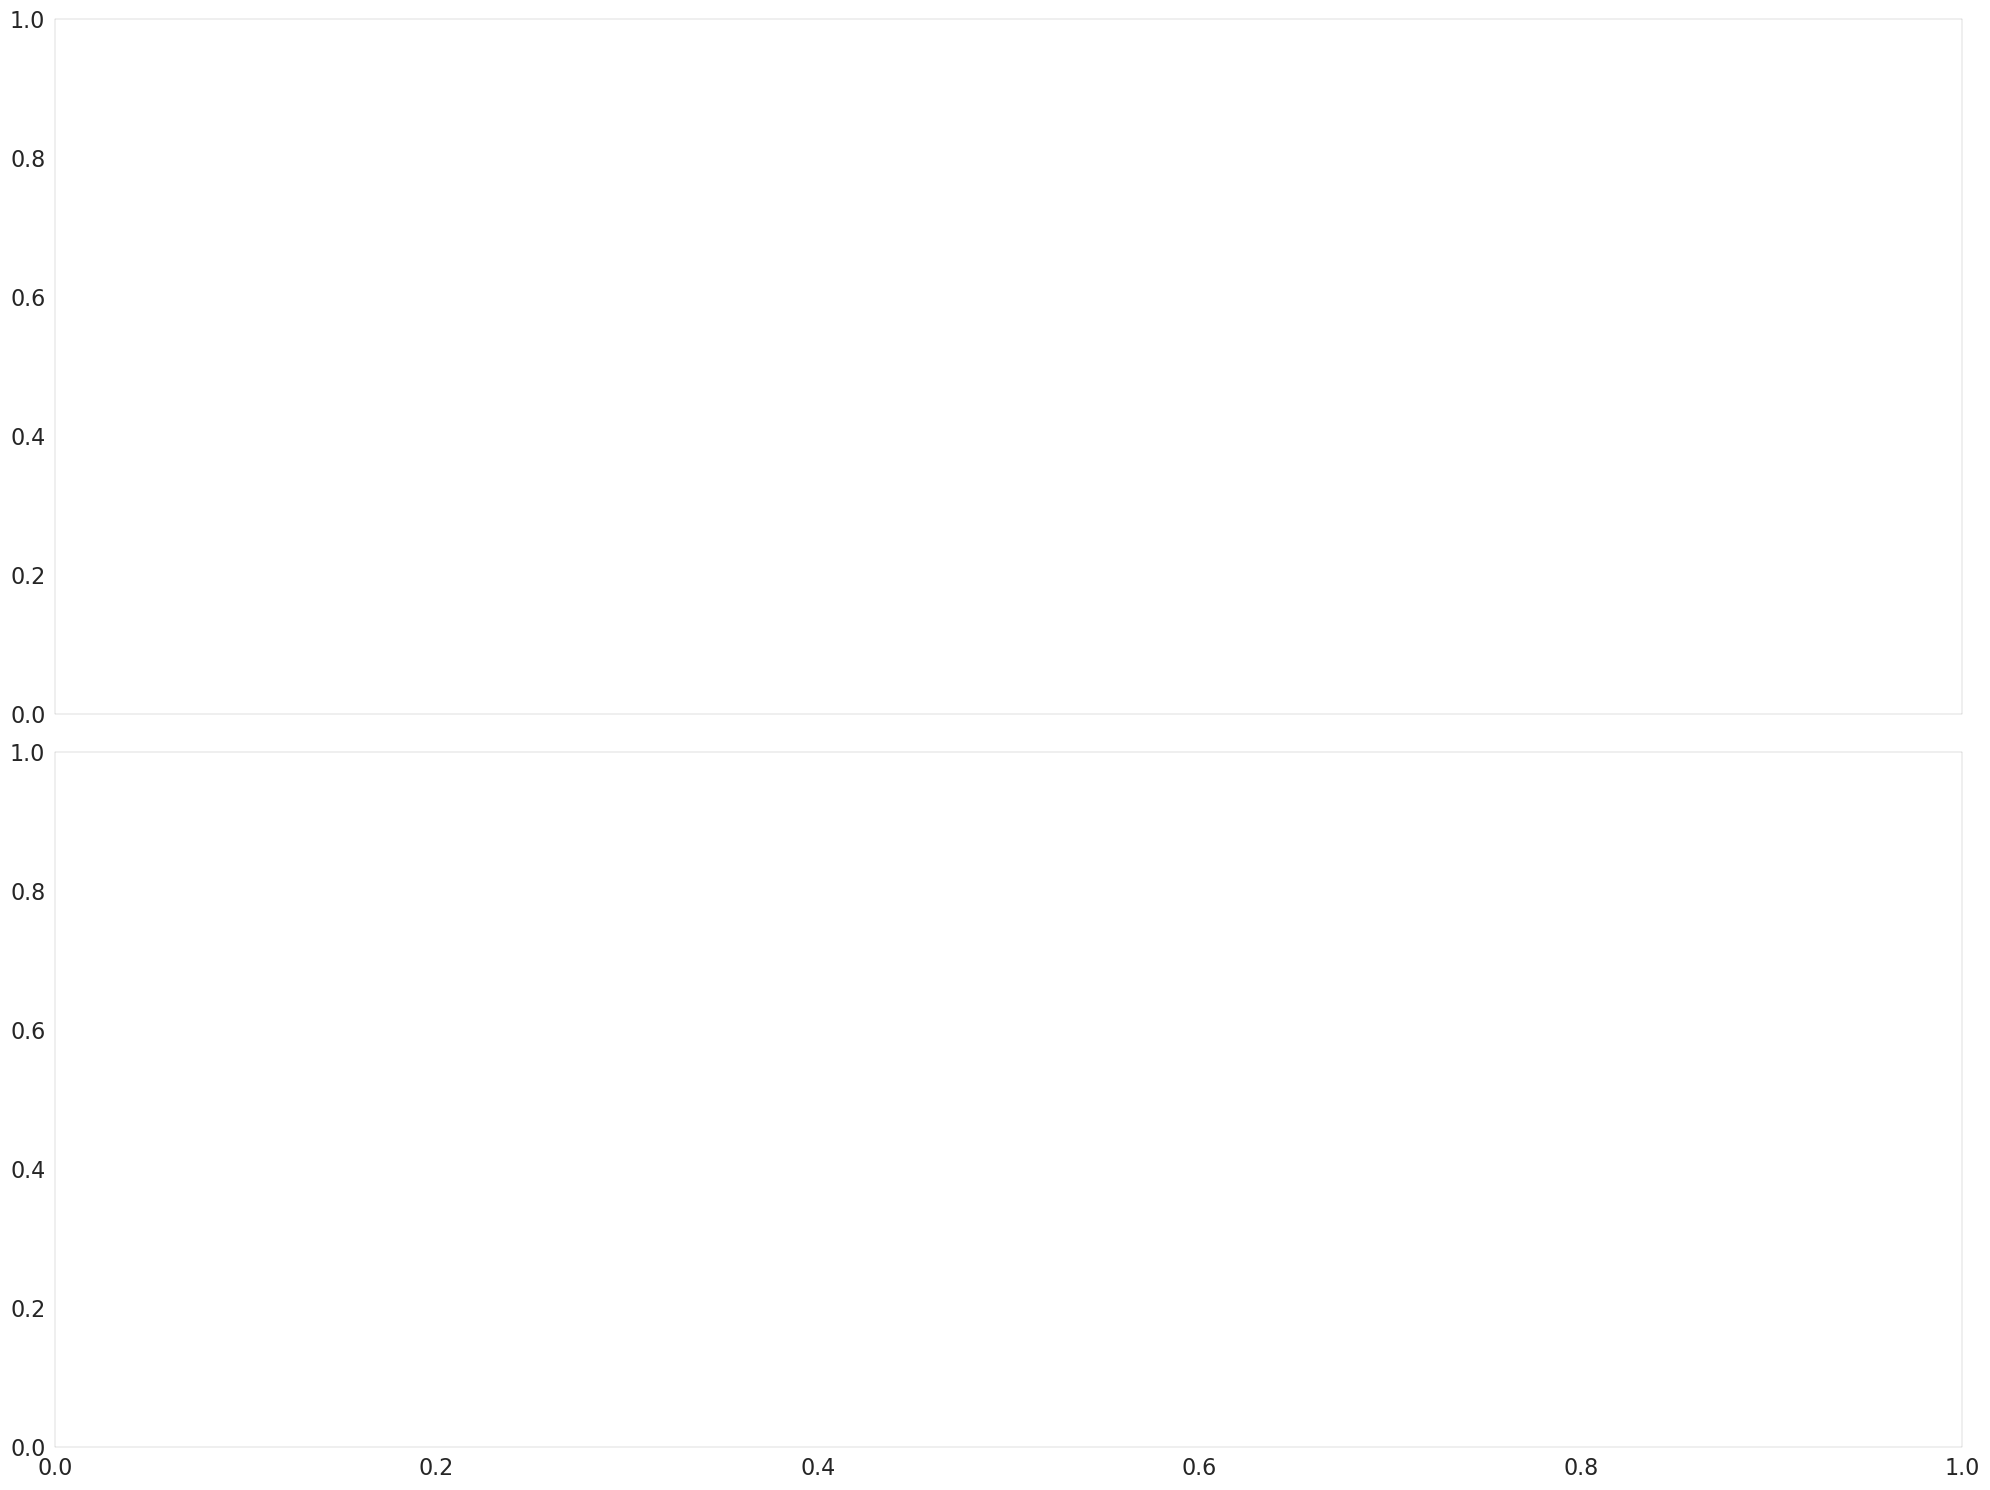

In [9]:
### Raster plot 
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(20,15))
idxs = np.argsort([np.argmax(r) for r in state_d1[:,1800:2450]])
idxs = [i for i in idxs if state_d1[:,16000:16800][i].max() > 0.00]
temp = state_d1[:,16000:16800]
axes[0].pcolormesh(temp[idxs], vmin=0.0, vmax=1.0, cmap='viridis', rasterized=True)

fig.text(-.025, .7, 'Neuron unit', rotation='vertical', fontsize=25)
fig.text(-.025, .2, 'Average firing rate', rotation='vertical', fontsize=25)

aim = state_d1[idxs[0:750],1500:2700]
reach = state_d1[idxs[750:1500],1500:2700]
lick = state_d1[idxs[1500:2250],1500:2700]
scavenge = state_d1[idxs[2250:3000],1500:2700]
axes[1].plot(np.average(aim, axis=0), linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(np.average(reach, axis=0), linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(np.average(lick, axis=0), linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(np.average(scavenge, axis=0), linestyle='dashdot', linewidth=3, color=colors[2])
axes[1].set_xlabel('Time (ms)', fontsize=25)
filename = 'segregated-population'
plt.savefig('/work/jp464/striatum-sequence/output/' + filename + '-raster' + '.svg', bbox_inches="tight", format='svg')
plt.show()

### Learning rate

### Phase diagram

In [ ]:
df = pd.read_hdf('/work/jp464/striatum-sequence/output/retrieval_speed.h5', 'data')
df

In [ ]:
def compute(x, y, z, df):
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    if len(target) == 0:
        return -1 
    return target.iloc[0, -2], target.iloc[0, -1]

def infer(x, y, z, df):
    seq, att = 0, 0
    for i in np.arange(-.6, .6, .2):
        for j in np.arange(-.6, .6, .2):
            score = compute(round(x+i,1), y, round(z+i,1), df)
            if score != -1:
                seq += score[0]
                att += score[1]
    if seq == 0 and att == 0:
        return 0
    elif seq >= att:
        return 10 
    else:
        return 5
    
def compute_score(x, y, z, df):
    x, y, z = round(x, 1), round(y, 1), round(z, 1)
    if x < 0.2 or z < 0.2 or y < 0.5:
        return 0
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    cnt = 0
    while len(target) == 0:
        if cnt > 10:
            z += 0.1
        else: z -= 0.1
        z = round(z,1)
        target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
        cnt += 1
    if cnt > 30:
        print(cnt)
    return infer(x,y,z,df)


In [ ]:
Nx, Ny, Nz =np.arange(0, 6.1, 0.2), np.arange(0, 6.1, 0.5), np.arange(0, 6.1, 0.2)
X, Y, Z = np.meshgrid(Nx, Ny, Nz)
data = np.zeros(X.shape)
ax1, ax2, ax3 = X.shape
for i in trange(ax1):
    for j in range(ax2):
        for k in range(ax3):
            data[i][j][k] = compute_score(X[i][j][k],Y[i][j][k],Z[i][j][k], df)

In [ ]:
slice = 12
mycmap1 = plt.get_cmap('viridis')
X1, Y1, Z1, data1 = X[slice:13,:,:], Y[slice:13,:,:], Z[slice:13,:,:], data[slice:13,:,:]
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}


# Create a figure with 3D ax
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X1[:, :, -1], Y1[:, :, -1], data1[:, :, -1],
    zdir='z', offset=Z1.max(), **kw, cmap=mycmap1
)
_ = ax.contourf(
    X1[0, :, :], data1[0, :, :], Z1[0, :, :],
    zdir='y', offset=Y1.min(), **kw, cmap=mycmap1
)
C = ax.contourf(
    data1[:, -1, :], Y1[:, -1, :], Z1[:, -1, :],
    zdir='x', offset=X1.max(), **kw, cmap=mycmap1
)

# Set limits of the plot from coord limits
xmin, xmax = X1.min(), X1.max()
ymin, ymax = Y1.min(), Y1.max()
zmin, zmax = Z1.min(), Z1.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
# ax.set(
#     xlabel=r'$A_{bc}$',
#     ylabel=r'$A_{cb}$',
#     zlabel=r'$A_{cc} = A_{bb}$', 
# )
ax.set_xlabel(r'$A_{bc}$', fontsize=20)
ax.set_ylabel(r'$A_{cb}$', fontsize=20)
ax.set_zlabel(r'$A_{cc} = A_{bb}$', fontsize=20)

# Set zoom and angle view
ax.view_init(0, 280, 0)
# ax.view_init(40, -40, 0)
ax.set_box_aspect(None, zoom=0.9)

# Show Figure
plt.savefig('/work/jp464/striatum-sequence/output/phase-plane12.svg', bbox_inches = "tight", format='svg')

plt.show()

In [ ]:
from matplotlib.pyplot import figure


def phase_diagram(df, Acb):
    points_att = df[df['Acb']==Acb][df['att']==True].to_numpy()
    points_seq = df[df['Acb']==Acb][df['seq']==True].to_numpy()
    x_att, y_att, x_seq, y_seq = points_att[:,1], points_att[:,0], points_seq[:,1], points_seq[:,0]
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(x_att, y_att, marker='^')
    ax.scatter(x_seq, y_seq, marker='o')
    ax.set_xlim(0,6.1)
    ax.set_ylim(0,6.1)
    plt.show()

In [ ]:
phase_diagram(df, Acb=1)

### Environmental variables dynamics

NameError: name 'mouse' is not defined

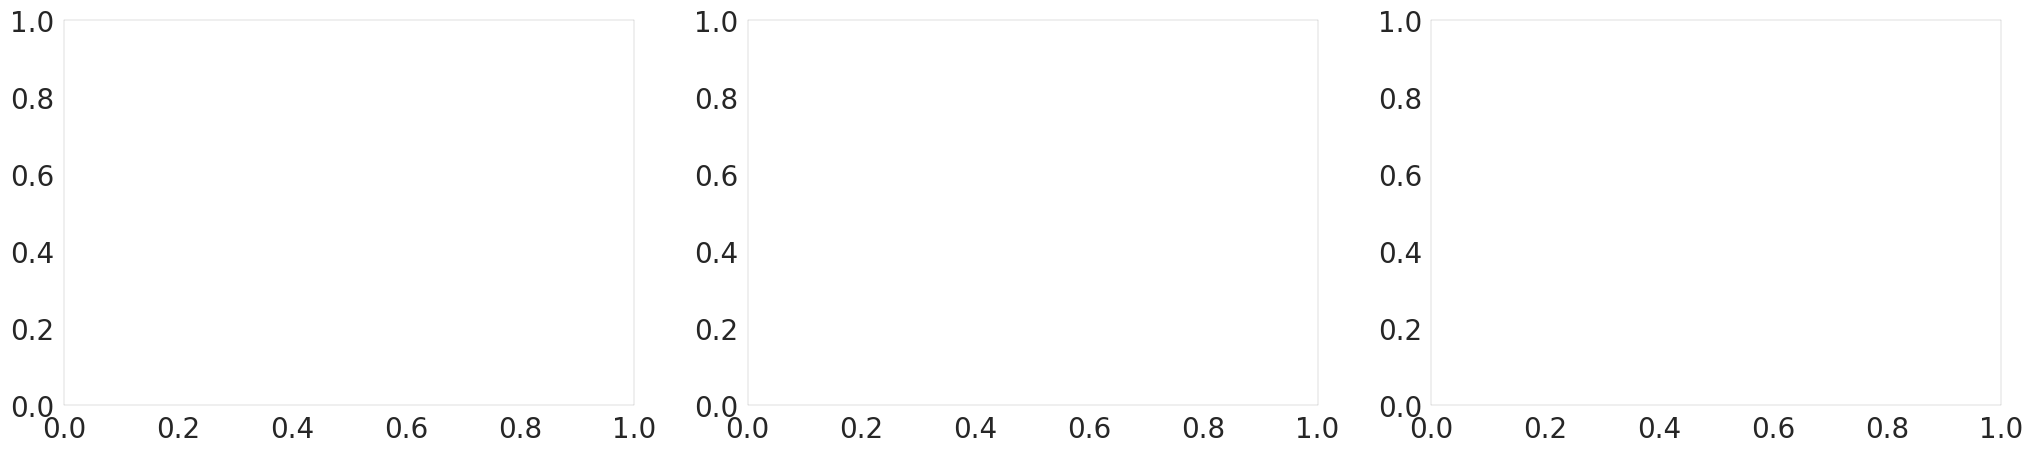

In [5]:
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1
start, end = 17800, 18200
fig, axs = fig1, axs1 = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
axs[0].scatter(range(end-start), mouse.evars[:,start:end][0], label='aim', color=colors[8])
axs[0].scatter(range(end-start), mouse.evars[:,start:end][1], label='reach', color=colors[0])
axs[0].scatter(range(end-start), mouse.evars[:,start:end][2], label='lick', color=colors[3])
axs[0].scatter(range(end-start), mouse.evars[:,start:end][3], label='scavenge', color=colors[2])
# axs[0].legend()
start, end = 25100, 25330
axs[1].scatter(range(end-start), mouse.evars[:,start:end][0], label='aim', color=colors[8])
axs[1].scatter(range(end-start), mouse.evars[:,start:end][1], label='reach', color=colors[0])
axs[1].scatter(range(end-start), mouse.evars[:,start:end][2], label='lick', color=colors[3])
axs[1].scatter(range(end-start), mouse.evars[:,start:end][3], label='scavenge', color=colors[2])
start, end = 25350, 25500
axs[2].scatter(range(end-start), mouse.evars[:,start:end][0], label='aim', color=colors[8])
axs[2].scatter(range(end-start), mouse.evars[:,start:end][1], label='reach', color=colors[0])
axs[2].scatter(range(end-start), mouse.evars[:,start:end][2], label='lick', color=colors[3])
axs[2].scatter(range(end-start), mouse.evars[:,start:end][3], label='scavenge', color=colors[2])
plt.savefig('/work/jp464/striatum-sequence/output/simulation-evars-dynamics.svg', bbox_inches = "tight", format='svg')


### Clustered Population

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

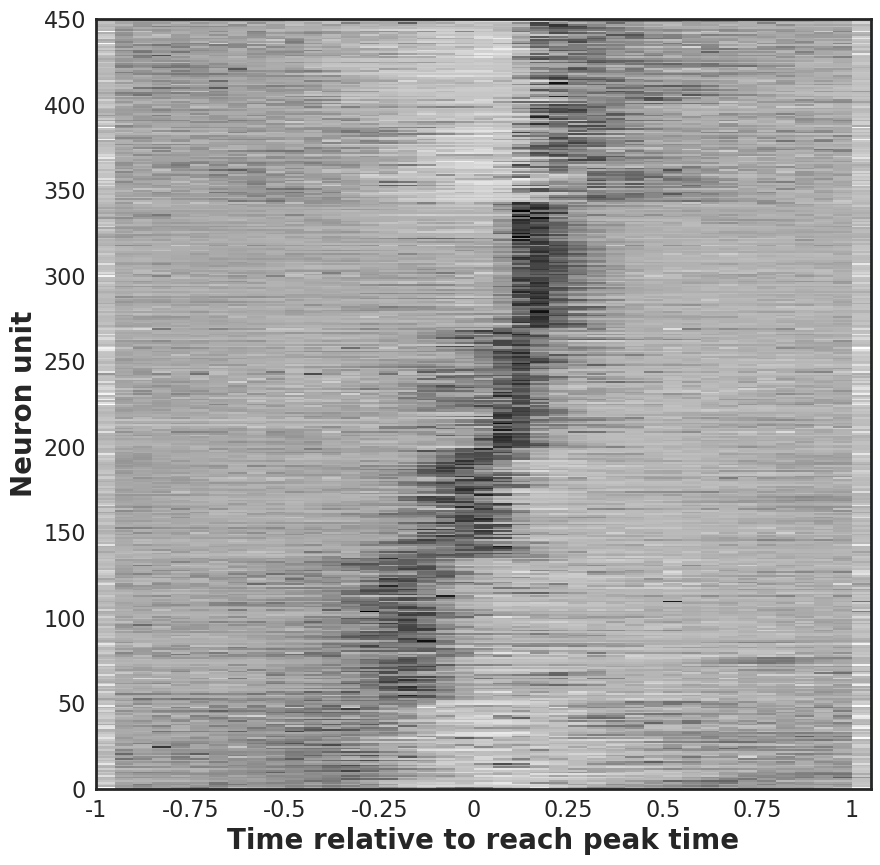

In [11]:
df = pd.read_excel('/work/jp464/striatum-sequence/output/data-clustered-population.xlsx')
time = df.iloc[1:,0].to_numpy()
time_idx = np.arange(0, len(time), 5)
group = df.iloc[0,1:].to_numpy()
mask1, mask2, mask3, mask4, mask5, mask6 = np.logical_and(group > 0.5, group < 1.5), np.logical_and(group > 1.5, group < 2.5), np.logical_and(group > 2.5, group < 3.5), np.logical_and(group > 3.5, group < 4.5), np.logical_and(group > 4.5, group < 5.5), np.logical_and(group > 5.5, group < 6.5)
group[mask1] = 5
group[mask2] = 4
group[mask3] = 2
group[mask4] = 1
group[mask5] = 3
group[mask6] = 6
neurons_idx = np.argsort(group)

data = df.iloc[1:,1:].to_numpy()
data2 = np.transpose(data[:,neurons_idx])
fig, ax = plt.subplots(figsize=[10,10])

ax.pcolormesh(data2,
          cmap='binary'
          )
ax.set_xticks(time_idx, time[time_idx])
ax.set_xlabel("Time relative to reach peak time", fontsize=20, fontname="arial", weight='bold')
ax.set_ylabel("Neuron unit", fontsize=20, fontname="arial", weight='bold')
plt.show()

### Firing rate

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

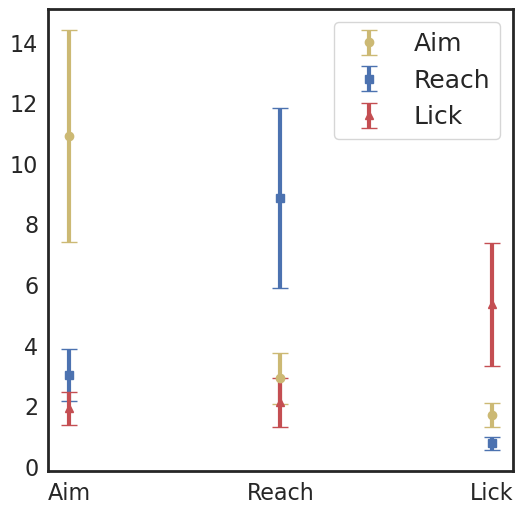

In [10]:
df = pd.read_excel('/work/jp464/striatum-sequence/output/data-firing-rate.xlsx')
aim = df.iloc[:,0:16].to_numpy()
reach = df.iloc[:,16:32].to_numpy()
lick = df.iloc[:,32:].to_numpy()
mean = np.vstack((np.mean(aim, axis=1), 
                  np.mean(reach, axis=1),
                  np.mean(lick, axis=1)))

sem = np.vstack((stats.sem(aim, axis=1), 
                  stats.sem(reach, axis=1),
                  stats.sem(lick, axis=1)))
fig, ax = plt.subplots(figsize=[6,6])
ax.errorbar([0,1,2], mean[:,0], sem[:,0], fmt='o', linewidth=3, capsize=6, label='Aim', color=colors[8])
ax.errorbar([0,1,2], mean[:,1], sem[:,1], fmt='s', linewidth=3, capsize=6, label='Reach', color=colors[0])
ax.errorbar([0,1,2], mean[:,2], sem[:,2], fmt='^', linewidth=3, capsize=6, label='Lick', color=colors[3])
ax.set_xticks([0,1,2], ['Aim', 'Reach', 'Lick'])
plt.legend()
plt.show()